In [33]:
import pandas as pd
import json
import hashlib
from tqdm import tqdm

In [19]:
from collections import OrderedDict
from copy import deepcopy 

def sortOD(od):
    res = OrderedDict()
    for k, v in sorted(od.items()):
        if isinstance(v, dict):
            res[k] = sortOD(v)
        else:
            res[k] = deepcopy(v)
    return res

In [5]:
l2s = []
with open('2023_q1_top_25_l2s.txt', 'r') as f:
    for l in f:
        if len(l.replace('\n', '').strip()) > 0:
            l2s.append(l.replace('\n', '').strip())

In [6]:
df_meta = pd.read_csv("Initial Attribute Definition for First Release - UPDATED SHEET .csv")

In [7]:
df_meta_25l2s = df_meta[df_meta.category.apply(lambda x: any([x.startswith(i) for i in l2s]))]

In [8]:
len(set(df_meta_25l2s.category.apply(lambda x: ' > '.join(x.split(' > ')[:2]))))

25

In [9]:
df_meta_25l2s['L2'] = df_meta_25l2s.category.apply(lambda x: ' > '.join(x.split(' > ')[:2]))

/tmp/ipykernel_13989/1116168472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_25l2s['L2'] = df_meta_25l2s.category.apply(lambda x: ' > '.join(x.split(' > ')[:2]))


In [10]:
df_meta_25l2s.groupby('L2').agg({
    'attribute_field': lambda x: len(set([i for i in x]))
})

,attribute_field
L2,
Cellphones & Telecommunications > Mobile Phone Accessories,38
Cellphones & Telecommunications > Phone Bags & Cases,14
Consumer Electronics > Earphones & Headphones,25
"Home & Garden > Arts, Crafts & Sewing",43
Home & Garden > Festive & Party Supplies,52
Home & Garden > Garden Supplies,41
Home & Garden > Home Decor,69
Home & Garden > Home Storage & Organization,35
Home & Garden > Home Textile,51


In [11]:
df_meta_25l2s_nofreetext = df_meta_25l2s[df_meta_25l2s['entry mode'] != 'free_text']

In [12]:
df_meta_25l2s_nofreetext.groupby('L2').agg({
    'attribute_field': lambda x: len(set([i for i in x]))
})

,attribute_field
L2,
Cellphones & Telecommunications > Mobile Phone Accessories,32
Cellphones & Telecommunications > Phone Bags & Cases,13
Consumer Electronics > Earphones & Headphones,24
"Home & Garden > Arts, Crafts & Sewing",24
Home & Garden > Festive & Party Supplies,40
Home & Garden > Garden Supplies,25
Home & Garden > Home Decor,52
Home & Garden > Home Storage & Organization,15
Home & Garden > Home Textile,37


In [13]:
df_query = pd.read_csv('../query_attr_extract_label/allstratified_sample_4806_query.csv')
df_product = pd.read_csv('../wish_attr_extract_label/sdt887_product_attribution_data_one_listing_per_leaf_node__20230111.csv')

# product

In [70]:
meta_dict = {}
for i in set(df_meta.category):
    meta_dict[i] = df_meta[(df_meta.category == i) & (df_meta['entry mode'] != 'free_text')].sort_values(
        "attribute_field"
    ).to_dict('records')

In [117]:
recs = []
for i in tqdm(df_product.to_dict('records')):
    if i['category_path'] in meta_dict:
        for j in meta_dict[i['category_path']]:
            rec = sortOD({
                "category_path": i['category_path'],
                "product_id": i['product_id'],
                "title": i['title'],
                "product_description": i['product_description'],
                "main_image_url": i['main_image_url'],
                "attribute_field": j['attribute_field'],
                "attribute_value": j['category_attributevalue'],
                "entry_mode": j['entry mode'],
                "max_multi_select": str(j['max_multi_select']),
                "attribute_description": j['description']
            })
            task_json = json.dumps(rec).encode('utf-8')
            task_hash = hashlib.md5(task_json).hexdigest()
            task_id = f"product_attribution_{task_hash}"
            rec['task_id'] = task_id
            recs.append(rec)

100%|██████████| 5033/5033 [00:00<00:00, 7408.45it/s]


In [118]:
tmp_df = pd.DataFrame(recs)

In [119]:
assert len(tmp_df) == len(set(tmp_df.task_id))

In [120]:
len(df_product), len(set(tmp_df['product_id']))

(5033, 1898)

In [121]:
tmp_df['entry_mode'].value_counts()

single_selection_only    9961
multi_selection_only     5476
Name: entry_mode, dtype: int64

<AxesSubplot: ylabel='Frequency'>

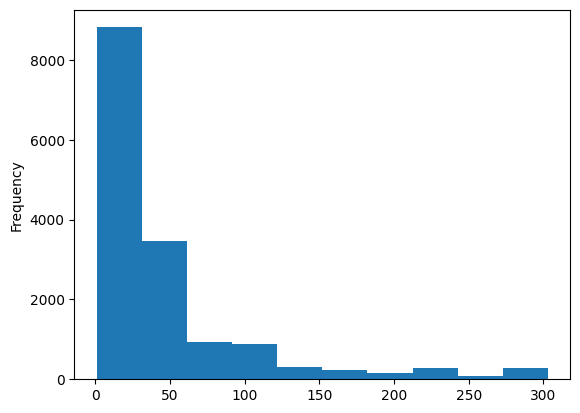

In [122]:
tmp_df['attribute_value'].apply(lambda x: len(eval(x))).plot.hist()

In [123]:
tmp_df[tmp_df['attribute_value'].apply(lambda x: len(eval(x)) == 1)].to_dict('records')

[{'attribute_description': 'Specifies the pattern or print of the item. Entered values that are not part of the attribute definition can impact listing exposure in browse and search.',
  'attribute_field': 'Pattern',
  'attribute_value': "['Throw']",
  'category_path': 'Home & Garden > Home Textile > Table & Sofa Linens > Sofa Covers',
  'entry_mode': 'single_selection_only',
  'main_image_url': 'https://canary.contestimg.wish.com/api/webimage/61540029c0236e7a45e4dc43-0-large.jpg',
  'max_multi_select': 'nan',
  'product_description': 'Production: Sofa Cover\nProcess Technique: Basic\nSeason: Spring and Summer\nFunction Type: All Cover\nis_customized: Yes\nStyle: Geometric\nMaterial: Polyester\nFabirc Construction: 90gsm\nSize: 90-140cm/145-185cm/195-230cm/235-300cm\nFabirc Style: Brushed\nProduction: Sofa Cover\nApplicable Sofa: Sectional Sofa\n1 seat: 90-140cm/35.43-55.12in\n2 seats: 145-185cm/57.09-72.83in\n3 seats: 190-230cm/74.80-90.55in\n4 seats: 235-300cm/92.52-118.11in\nWeight:

In [132]:
tmp_df['max_multi_select'].min()

'2.0'

In [131]:
len(set(tmp_df['attribute_value']))

855

In [133]:
import xlsxwriter
from xlsxwriter.utility import xl_rowcol_to_cell


In [136]:
''.join(['$' + i for i in xl_rowcol_to_cell(0,0)])

'$A$1'

In [141]:

attr_val_set_to_cell_range = {}

workbook = xlsxwriter.Workbook('../wish_attr_extract_label/offshore_excel/sdt887_product_attribution_data_one_listing_per_leaf_node__20230111_25l2subset_offshoreexcel_20230119.xlsx')
worksheet = workbook.add_worksheet('attribute_val')
worksheet2 = workbook.add_worksheet('attribute_definition')

r = 0
for i in set(tmp_df['attribute_value']):
    c = 0
    start_cell = xl_rowcol_to_cell(r, c, row_abs=True, col_abs=True)
    end_cell = xl_rowcol_to_cell(r, c, row_abs=True, col_abs=True)
    for j in eval(i):
        worksheet2.write(r, c, j)
        end_cell = xl_rowcol_to_cell(r, c, row_abs=True, col_abs=True)
        c += 1
    attr_val_set_to_cell_range[i] = f'=attribute_definition!{start_cell}:{end_cell}'
    r += 1

worksheet2.write(3, 4, "hello1")
worksheet2.write(3, 5, "hello2")
worksheet2.write(3, 6, "hello3")

cols = ['task_id', 'title', 'product_description', 'main_image_url', 'attribute_field', 
    'entry_mode', 'max_multi_select', 'attribute_value']

r = 0
for c in range(len(cols)):
    worksheet.write(r, c, cols[c])

r += 1
for i in tqdm(recs):
    for c in range(len(cols)):
        if cols[c] != 'attribute_value':
            worksheet.write(r, c, i[cols[c]])
        else:
            worksheet.data_validation(r, c, r, c, {
                'validate': 'list',
                'source': attr_val_set_to_cell_range[i[cols[c]]],
                'input_message': i['attribute_description']
            })
    r += 1
workbook.close()

100%|██████████| 15437/15437 [00:01<00:00, 9072.34it/s] 


In [142]:
attr_val_set_to_cell_range[i[cols[c]]]

'=attribute_definition!$A$849:$AZ$849'